In [3]:
##################################
# Imports -----------------------#
##################################
import numpy as np
import galsim
from numpy import random
from astropy import nddata
from astropy.io import fits
from pysersic import FitSingle
from pysersic import check_input_data
from pysersic.priors import SourceProperties
from pysersic.loss import gaussian_loss
from jax.random import PRNGKey 
import matplotlib.pyplot as plt

In [4]:
##################################
# Helper Functions --------------#
##################################

# (I am tired of typing these out individually and should have done this a long time ago)
def print_stats(arr):
    print(f"Mean: {np.mean(arr)}")
    print(f"Median: {np.median(arr)}")
    print(f"Max: {np.max(arr)}")
    print(f"Min: {np.min(arr)}")
    print()
    return [np.mean(arr), np.median(arr), np.max(arr), np.min(arr)]
    
# generates an array of 0s with dimensions of generated Galsim galaxy
def gen_mask(image_shape):
    import jax.numpy as jnp
    return jnp.array(np.zeros(image_shape))

In [5]:
##################################
# Initializing Test Parameters --#
##################################

tests = 500
n = np.random.uniform(1, 6, tests) 
flux = np.random.uniform(25, 36, tests) 
r_eff = np.random.uniform(1, 5, tests) #3.29219
image_size = 35

# arrays of difference abs(actual - predicted) value
n_difference = []
reff_difference = []
flux_difference = []

# let the testing begin...
for i in range(tests):
    # print actual sersic values
    # print("Actual Sersic Values: ")
    # print(f"n:     {n[i]}")
    # print(f"flux:  {flux[i]}")
    # print(f"r_eff: {r_eff[i]}")

    # creating variance image --> (n value seems to be entirely dependent on the variance for some reason...)
    cutout_var = [[random.rand()*0.0008 for i in range(image_size)] for j in range(image_size)]

    # creating fake galaxy
    obj = galsim.Sersic(n[i], flux=flux[i], half_light_radius=r_eff[i])
    
    # visualize fake galaxy if desired
    # fig, ax1 = plt.subplots(1,1)
    # ax1.imshow(fake_galaxy,cmap="gray",origin="lower",vmin=0,vmax=0.1)
    
    # creating psf image
    psf = galsim.Gaussian(half_light_radius=r_eff[i])#fwhm=psf_fwhm)
    psf_image = psf.drawImage(nx=image_size, ny=image_size, scale=1.0).array
    
    # convolve galaxy with PSF
    convolved_galaxy = galsim.Convolve([obj, psf])

    # draw image
    image = galsim.ImageF(image_size, image_size)
    convolved_galaxy.drawImage(image, scale=1)
    
    # finding galaxy image with added noise
    fake_galaxy = image.array + cutout_var
    
    # determining center & shape of cutout (assuming source is at center)
    y_center, x_center = fake_galaxy.shape[0]//2, fake_galaxy.shape[1]//2
    x_len,y_len = fake_galaxy.shape
    
    # initializing min-length
    min_length = 12 #22
    
    # filter cutouts (cutouts too small are normally too cropped & cutouts that are too large are normally two different sources mistaken as one)
    if (x_len> 10 and y_len > 10 and x_len < 40 and y_len < 40):
        # create size buffer
        length = max([x_len, y_len, min_length]) * 1.25

        # creating cutout; generating mask 
        my_cutout = nddata.Cutout2D(fake_galaxy, (x_center,y_center), int(length))
        cutout_mask = gen_mask(my_cutout.shape)
        
        # normalizing psf
        normalized_psf = psf_image/np.sum(psf_image)
        
        # checking validity of parameters (can use if desired)
        # check_input_data(my_cutout.data,cutout_var, normalized_psf, cutout_mask)    
        
        props = SourceProperties(my_cutout.data,mask=cutout_mask) 
        
        # generating estimate of parameters
        prior = props.generate_prior('sersic',sky_type='none')
        
        # fitting
        fitter = FitSingle(data=my_cutout.data,rms=cutout_var, psf=normalized_psf, prior=prior, mask=cutout_mask, loss_func=gaussian_loss) 
        sersic_values = fitter.find_MAP(rkey = PRNGKey(1000));            # dictionary with n, xc, yc, flux, r_eff, model ...
        
        # plotting residual if desired
        # fig, ax = plot_residual(my_cutout.data,map_params['model'],mask=cutout_mask,vmin=0,vmax=0.1);

        # printing predicted sersic values
        # print("Fitted Sersic Values: ")
        # print(f"n:     {sersic_values['n']}")
        # print(f"flux:  {sersic_values['flux']}")
        # print(f"r_eff: {sersic_values['r_eff']}")
        
        # append difference to be analyzed...
        n_difference.append(n[i] - sersic_values['n'])
        reff_difference.append(r_eff[i] - sersic_values['r_eff'])
        flux_difference.append(flux[i] - sersic_values['flux'])
    else:
        print("image is too big or too small")

# outputting the stats
print('Absolute Value of Actual - Predicted Difference Stats')
print('Sersic index (n)')
n_stats = print_stats(np.abs(n_difference))
print('Effective Radius (r_eff)')
reff_stats = print_stats(np.abs(reff_difference))
print('Flux Difference (flux)')
flux_stats = print_stats(np.abs(flux_difference))

  3%|▎         | 258/10000 [00:00<00:03, 2521.31it/s, Round = 2,step_size = 1.0e-04 loss: 2.035e+05]

Absolute Value of Actual - Predicted Difference Stats
Sersic index (n)
Mean: 0.5558508696392915
Median: 0.249046272416393
Max: 3.1284655018779395
Min: 5.908778855134855e-05

Effective Radius (r_eff)
Mean: 0.2226243010186323
Median: 0.04734886334473454
Max: 1.362051915745718
Min: 4.159787741486731e-05

Flux Difference (flux)
Mean: 1.3251802076924455
Median: 0.6015585397930927
Max: 5.94018367512685
Min: 0.000587477064911468



Text(0.5, 0.98, 'Displaying Residual of Sersic Values')

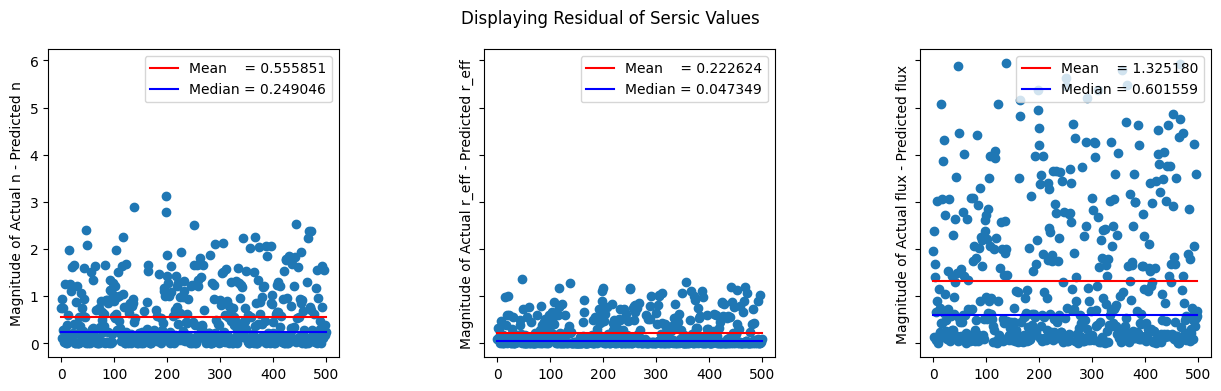

In [6]:
########################################
# Graphically Displaying Differences --#
########################################

fig, axes = plt.subplots(1,3,sharey=True, figsize=(15,4))
plt.subplots_adjust(wspace=0.5)

x_axis = [i for i in range(len(n_difference))]
axes[0].scatter(x_axis,np.abs(n_difference))
axes[0].set(ylabel="Magnitude of Actual n - Predicted n")
axes[0].plot([n_stats[0] for i in range(len(x_axis))],color='red',label=f'Mean    = {n_stats[0]:.6f}')
axes[0].plot([n_stats[1] for i in range(len(x_axis))],color='blue',label=f'Median = {n_stats[1]:.6f}')

axes[1].scatter(x_axis,np.abs(reff_difference))
axes[1].set(ylabel="Magnitude of Actual r_eff - Predicted r_eff")
axes[1].plot([reff_stats[0] for i in range(len(x_axis))],color='red',label=f'Mean    = {reff_stats[0]:.6f}')
axes[1].plot([reff_stats[1] for i in range(len(x_axis))],color='blue',label=f'Median = {reff_stats[1]:.6f}')

axes[2].scatter(x_axis,np.abs(flux_difference))
axes[2].set(ylabel="Magnitude of Actual flux - Predicted flux")
axes[2].plot([flux_stats[0] for i in range(len(x_axis))],color='red',label=f'Mean    = {flux_stats[0]:.6f}')
axes[2].plot([flux_stats[1] for i in range(len(x_axis))],color='blue',label=f'Median = {flux_stats[1]:.6f}')

leg = axes[0].legend(loc='upper right')
leg = axes[1].legend(loc='upper right')
leg = axes[2].legend(loc='upper right')

plt.suptitle('Displaying Residual of Sersic Values')



In [9]:
########################################
# Finding Error Percentages -----------#
########################################
n_percenterr    = n_difference/n * 100
reff_percenterr = reff_difference/r_eff * 100
flux_percenterr = flux_difference/flux * 100

# finding average error
n_avg_err, reff_avg_err, flux_avg_err = np.median(np.abs(n_percenterr)), np.median(np.abs(reff_percenterr)), np.median(np.abs(flux_percenterr))

# displaying values
print(f"Average Sersic index error of script:     {n_avg_err}")
print(f"Average effective radius error of script: {reff_avg_err}")
print(f"Average flux error of script:             {flux_avg_err}")
print()

# finding total error (not ideal representation: affected by skewed data)
n_percenterr_sum    = np.sum(np.abs(n_difference))/np.sum(np.abs(n)) * 100
reff_percenterr_sum = np.sum(np.abs(reff_difference))/np.sum(np.abs(r_eff)) * 100
flux_percenterr_sum = np.sum(np.abs(flux_difference))/np.sum(np.abs(flux)) * 100

# displaying values
print(f"Total Sersic index error of script:     {n_percenterr_sum}")
print(f"Total effective radius error of script: {reff_percenterr_sum}")
print(f"Total flux error of script:             {flux_percenterr_sum}")


16.13837696626633 7.446289248310715
